In [1]:
from datetime import datetime
import ujson as json
import os
import sys

from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
from scipy.stats import shapiro, ttest_ind
from statsmodels.stats.weightstats import ztest

sys.path.append(os.path.expanduser("~/GitHub/EvenTDT"))
sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))

from eventdt import twitter
from multiplex import drawable

events = [ "#CRYCHE", "#SOUARS", "#TURITA", "#LIVATM" ]
original = [ os.path.expanduser(f"~/DATA/c5-evaluation/{ event }/event.json") for event in events ]
downloaded = [ os.path.expanduser(f"~/DATA/c5-evaluation/{ event }/downloaded.json") for event in events ]

# the #LIVATM match has the tweet IDs instead of the full corpus
downloaded[-1] = os.path.expanduser(f"~/DATA/c5-evaluation/#LIVATM/ids-20211104.csv")

In [2]:
dfs = dict.fromkeys(events, None)

for event, og, dl in zip(events, original, downloaded):
    print(event)
    with open(dl, 'r') as f:
        if dl.endswith('.csv'):
            ids = [ tid.strip() for tid in f ]
        elif dl.endswith('.json'):
            ids = [ json.loads(tweet)['id_str'] for tweet in f ] # downloaded tweets
    
    data = { }
    with open(og, 'r') as f:
        for i, tweet in enumerate(f):
            tweet = json.loads(tweet)
            text = twitter.full_text(tweet)
            id_str = tweet['id_str']
            available = id_str in ids

            # user features
            screen_name = tweet['user']['screen_name']
            friends_count = int(tweet['user']['friends_count'])
            followers_count = int(tweet['user']['followers_count'])
            has_followers = followers_count > 0
            favourites_count = int(tweet['user']['favourites_count'])
            description = len(tweet['user']['description']) if tweet['user']['description'] else 0
            has_description = description > 0
            statuses_count = int(tweet['user']['statuses_count'])
            verified = tweet['user']['verified']
            # the age is in days
            age = (twitter.extract_timestamp(tweet) - parse(tweet['user']['created_at']).timestamp()) / 60 / 60 / 24
            is_new = age <= 7

            # data features
            timestamp = twitter.extract_timestamp(tweet)
            hashtags = len(tweet['entities']['hashtags'])
            urls = len(tweet['entities']['urls'])
            has_urls = urls > 0
            mentions = len(tweet['entities']['user_mentions'])
            is_retweet = twitter.is_retweet(tweet)
            is_quote = twitter.is_quote(tweet)

            data[i] = { 'event': event, 'id': id_str, 'available': available, 'timestamp': timestamp, 'screen_name': screen_name,

                        'friends_count': friends_count, 'followers_count': followers_count, 'has_followers': has_followers,
                        'favourites_count': favourites_count, 'statuses_count': statuses_count,
                        'age': age, 'is_new': is_new, 'description': description, 'has_description': has_description,
                        'verified': verified,

                        'hashtags': hashtags, 'urls': urls, 'has_url': has_urls, 'mentions': mentions,
                        'is_retweet': is_retweet, 'is_quote': is_quote,

                        'text': text }
            if i and not (i % 10000):
                print(f"{ i } tweets read")

        df = pd.DataFrame.from_dict(data, "index")
        df['has_stream'] = df.text.apply(lambda _text: 'stream' in _text.lower() )
        df['elapsed'] = df['timestamp'] - df['timestamp'].min()
        dfs[event] = df

#CRYCHE
10000 tweets read
20000 tweets read
30000 tweets read
40000 tweets read
50000 tweets read
60000 tweets read
#SOUARS
10000 tweets read
20000 tweets read
30000 tweets read
40000 tweets read
50000 tweets read
60000 tweets read
70000 tweets read
80000 tweets read
90000 tweets read
#TURITA
10000 tweets read
20000 tweets read
30000 tweets read
40000 tweets read
50000 tweets read
60000 tweets read
70000 tweets read
80000 tweets read
90000 tweets read
100000 tweets read
#LIVATM
10000 tweets read
20000 tweets read
30000 tweets read
40000 tweets read
50000 tweets read
60000 tweets read
70000 tweets read
80000 tweets read
90000 tweets read
100000 tweets read


In [3]:
dfs['#LIVATM'].head()

,event,id,available,timestamp,screen_name,friends_count,followers_count,has_followers,favourites_count,statuses_count,...,verified,hashtags,urls,has_url,mentions,is_retweet,is_quote,text,has_stream,elapsed
0,#LIVATM,1455984356821020679,True,1.635969e+09,reds4us,105,5487,True,145,140155,...,False,0,0,False,1,True,False,Milan and Porto finishes 1-1 at San Siro.\n\nW...,False,0.0
1,#LIVATM,1455984357118812160,False,1.635969e+09,Lord_Taki_J,858,686,True,5912,59725,...,False,0,0,False,1,True,False,AC Milan have drew 1-1 with Porto tonight in t...,False,0.0
2,#LIVATM,1455984358204985344,True,1.635969e+09,AshleyGHATER,6,0,False,8,17,...,False,0,1,True,1,False,True,It's time to Watch UCL:: PSG VS RB Leipzig Liv...,True,0.0
3,#LIVATM,1455984359131987970,True,1.635969e+09,UTD_Lelon,964,595,True,20756,2325,...,False,0,0,False,0,False,False,I actually don't know what to watch tonight.\n...,False,0.0
4,#LIVATM,1455984359773769736,True,1.635969e+09,chooseleticiam,35,7,True,6,182,...,False,1,1,True,1,True,False,live broadcast Liverpool vs Atletico Madrid\n\...,False,0.0


## Availability distribution

In [4]:
width = 15 # minutes
adf = pd.DataFrame()
for df in dfs.values():
    df['bin'] = df.elapsed - df.elapsed % (60 * width)
    available = df[df['available'] == True].groupby(by='bin').count()['available'] # count the number of available tweets in each bin
    bins = df.groupby(by='bin').count()['available']
    available = available.div(bins, level='bin')
    adf = adf.append(available, ignore_index=True)

adf = adf.dropna(axis=1) # remove bins with NA values
adf.mean()

0.0       0.699985
900.0     0.694452
1800.0    0.744863
2700.0    0.751289
3600.0    0.782489
4500.0    0.760170
5400.0    0.766803
6300.0    0.786051
7200.0    0.812747
dtype: float64

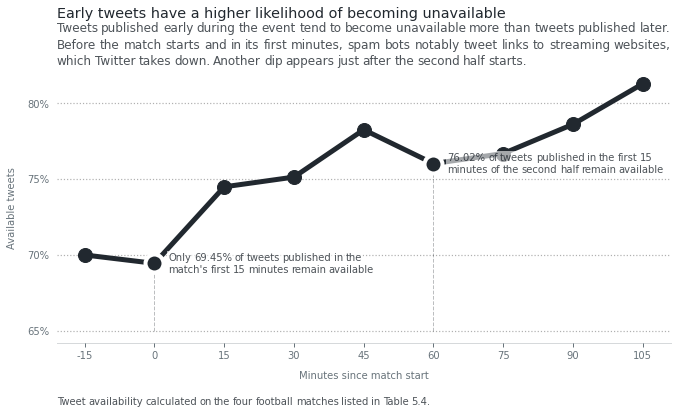

In [5]:
# create a style
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 5, 'with_legend': True, 'zorder': 1,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 14 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 2 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 18, 'markeredgewidth': 4, 'markeredgecolor': 'C4' }) # 18-4=14 (markersize)
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller', 'va': 'center', 'alpha': 0.8, 'facecolor': '#ffffff99', 'pad': 1 }

# prepare the data
means = adf.mean()
x, y = list(means.index), list(means)
xticks, tickvalues = x[0::1], y[0::1]
lowest = means[means == min(means)]
annotations = {
    lowest.index[0]: f"Only { round(lowest.item() * 100, 2) }% of tweets published in the match's first 15 minutes remain available",
    75*60: f"{ round(means[75*60].item() * 100, 2) }% of tweets published in the first 15 minutes of the second half remain available",
}

# create the visualization
figure = plt.figure(figsize=(11, 5))
viz = drawable.Drawable(figure)

# viz.fill_between(x, y-adf.std(), y+adf.std(), alpha=0.2, color='C1')
viz.draw_time_series(x, y, **style)
viz.scatter(xticks, tickvalues, color='C0', **scatter_style)

# finalize the visualization
viz.set_xlabel('Minutes since match start')
viz.set_ylabel('Available tweets')
viz.set_yticks([ _y/100 for _y in range(65, 85, 5) ])
viz.set_yticklabels([ f"{ round(ytick * 100) }%" for ytick in viz.get_yticks() ])
viz.set_xticks(xticks)
viz.set_xticklabels([ round(x / 60 - 15) for x in xticks ])
viz.set_axisbelow(True)
viz.set_title("Early tweets have a higher likelihood of becoming unavailable", loc='left')
viz.set_caption(f"""Tweets published early during the event tend to become unavailable more than tweets published later.
                    Before the match starts and in its first minutes, spam bots notably tweet links to streaming websites, which Twitter takes down.
                    Another dip appears just after the second half starts.""",
                align='justify')

# draw the annotations
ylim = viz.get_ylim()
for x, label in annotations.items():
    y = means[x].item()
    viz.vlines(x, ymin=ylim[0], ymax=y, **line_style)
    viz.plot(x, y, color='C0', **annotation_marker_style)
    viz.annotate(label, (x + 3*60, x + 50*60), y, **annotation_style)

viz.set_footnote("Tweet availability calculated on the four football matches listed in Table 5.4.")
viz.savefig('../exports/5.3-timing-of-missing-tweets.png', dpi=300, bbox_inches='tight')

## Stream distribution

In [6]:
width = 15 # minutes
sdf = pd.DataFrame()
for df in dfs.values():
    df['bin'] = df.elapsed - df.elapsed % (60 * width)
    has_stream = df[df['has_stream'] == True].groupby(by='bin').count()['has_stream'] # tweets mentioning 'stream' in each bin
    bins = df.groupby(by='bin').count()['has_stream'] # tweets in each bin
    has_stream = has_stream.div(bins, level='bin')
    sdf = sdf.append(has_stream, ignore_index=True)

sdf = sdf.dropna(axis=1) # remove bins with NA values
sdf.mean()

0.0       0.118811
900.0     0.109028
1800.0    0.047490
2700.0    0.032438
3600.0    0.022618
4500.0    0.034885
5400.0    0.030418
6300.0    0.012872
7200.0    0.003172
dtype: float64

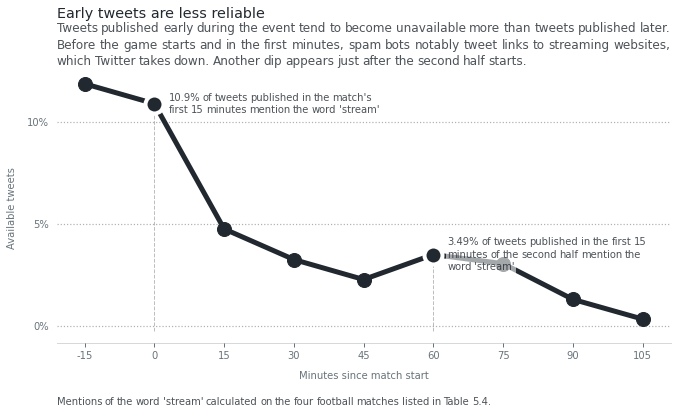

In [7]:
# create a style
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 5, 'with_legend': True, 'zorder': 1,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 14 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 2 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 18, 'markeredgewidth': 4, 'markeredgecolor': 'C4' }) # 18-4=14 (markersize)
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller', 'va': 'center', 'alpha': 0.8, 'facecolor': '#ffffff99', 'pad': 1 }

# prepare the data
means = sdf.mean()
x, y = list(means.index), list(means)
xticks, tickvalues = x[0::1], y[0::1]
annotations = {
    15*60: f"{ round(means[15*60].item() * 100, 2) }% of tweets published in the match's first 15 minutes mention the word 'stream'",
    75*60: f"{ round(means[75*60].item() * 100, 2) }% of tweets published in the first 15 minutes of the second half mention the word 'stream'",
}

# create the visualization
figure = plt.figure(figsize=(11, 5))
viz = drawable.Drawable(figure)

# viz.fill_between(x, y-sdf.std(), y+sdf.std(), alpha=0.2, color='C1')
viz.draw_time_series(x, y, **style)
viz.scatter(xticks, tickvalues, color='C0', **scatter_style)

# finalize the visualization
viz.set_xlabel('Minutes since match start')
viz.set_ylabel('Available tweets')
viz.set_yticks([ _y/100 for _y in range(0, 20, 5) ])
viz.set_yticklabels([ f"{ round(ytick * 100) }%" for ytick in viz.get_yticks() ])
viz.set_xticks(xticks)
viz.set_xticklabels([ round(x / 60 - 15) for x in xticks ])
viz.set_axisbelow(True)
viz.set_title("Early tweets are less reliable", loc='left')
viz.set_caption(f"""Tweets published early during the event tend to become unavailable more than tweets published later.
                    Before the game starts and in the first minutes, spam bots notably tweet links to streaming websites, which Twitter takes down.
                    Another dip appears just after the second half starts.""",
                align='justify')

# draw the annotations
ylim = viz.get_ylim()
for x, label in annotations.items():
    y = means[x].item()
    viz.vlines(x, ymin=ylim[0], ymax=y, **line_style)
    viz.plot(x, y, color='C0', **annotation_marker_style)
    viz.annotate(label, (x + 3*60, x + 50*60), y, **annotation_style)

viz.set_footnote("Mentions of the word 'stream' calculated on the four football matches listed in Table 5.4.")
viz.savefig('../exports/5.3-timing-of-stream-tweets.png', dpi=300, bbox_inches='tight')

Correlation

In [8]:
import scipy
scipy.stats.pearsonr(adf.mean(), sdf.mean())

(-0.9621775624696511, 3.338730540792937e-05)